In [1]:
s3_data ="s3://aegovan-data/processed_dataset/test_unique_pub_v6_max_neg.json"
data_dir = "temp"


In [2]:
!rm -rf $data_dir
!mkdir $data_dir
!aws s3 cp s3://aegovan-data/results/ppi-bert-extractor-neg-2019-11-02-08-08-28-562/output/output.tar.gz  $data_dir

download: s3://aegovan-data/results/ppi-bert-extractor-neg-2019-11-02-08-08-28-562/output/output.tar.gz to temp/output.tar.gz


In [3]:
!tar -xf $data_dir/output.tar.gz -C $data_dir


In [4]:
!rm $data_dir/output.tar.gz


In [5]:
!ls -l $data_dir

total 5192
-rw-r--r--  1 aeg  1896053708  2648516 Nov  2 21:09 predicted.json
-rw-r--r--  1 aeg  1896053708     3059 Nov  2 21:09 training_scores_epoch_Objectdump_20191102_100917_1e53e8ef-0eac-4f94-9db0-510a146f5a58.json
-rw-r--r--  1 aeg  1896053708     3065 Nov  2 21:09 validation_scores_epoch_Objectdump_20191102_100917_250f9b10-8cba-4aeb-a1bb-b621bb90ec24.json


In [6]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

In [7]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)



In [8]:
import glob, os

test_input_file = os.path.join(data_dir, "test.json")
results_file = os.path.join(data_dir, "predicted.json")
validation_fit_file = glob.glob("{}/validation_scores_epoch_Objectdump*.json".format(data_dir))[0]
train_fit_file = glob.glob("{}/training_scores_epoch_Objectdump*.json".format(data_dir))[0]


pos_label = True

In [9]:
#download_single_file(s3_data, test_input_file)

In [10]:
import pandas as pd

In [11]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [12]:
df_results = pd.read_json(results_file)
df_results["actual"] = df_results["class"]

In [13]:
df_results.columns


Index(['pubmedabstract', 'normalised_abstract', 'participant1Id',
       'participant2Id', 'class', 'predicted', 'confidence_scores', 'actual'],
      dtype='object')

In [14]:
df_results.shape

(894, 8)

In [15]:
df_results.head(n=2)

,pubmedabstract,normalised_abstract,participant1Id,participant2Id,class,predicted,confidence_scores,actual
0,"MAPK/ERK kinase kinase 3 (MEKK3) is a mitogen-activated protein kinase kinase kinase (MAP3K) that functions upstream of the MAP kinases and IkappaB kinase. Phosphorylation is believed to be a critical component for MEKK3-dependent signal transduction, but little is known about the phosphorylation sites of this MAP3K. To address this question, point mutations were introduced in the activation loop (T-loop), substituting alanine for serine or threonine, and the mutants were transfected into HEK293 Epstein-Barr virus nuclear antigen cells. MEKK3-dependent activation of an NF-kappaB reporter gene as well as ERK, JNK, and p38 MAP kinases correlated with a requirement for serine at position 526. Constitutively active mutants of MEKK3, consisting of S526D and S526E, were capable of activating a NF-kappaB luciferase reporter gene as well as ERK and MEK, suggesting that a negative charge at Ser526 was necessary for MEKK3 activity and implicating Ser526 as a phosphorylation site. An antibody was developed that specifically recognized phospho-Ser526 of MEKK3 but did not recognize the S526A point mutant. The catalytically inactive (K391M) mutant of MEKK3 was not phosphorylated at Ser526, indicating that phosphorylation of Ser526 occurs via autophosphorylation. Endogenous MEKK3 was phosphorylated on Ser526 in response to osmotic stress. In addition, phosphorylation of Ser526 was required for MKK6 phosphorylation in vitro, whereas dephosphorylation of Ser526 was mediated by protein phosphatase 2A and sensitive to okadaic acid and sodium fluoride. Finally, the association between MEKK3 and 14-3-3 was dependent on Ser526 and prevented dephosphorylation of Ser526. In summary, Ser526 of MEKK3 is an autophosphorylation site within the T-loop that is regulated by PP2A and 14-3-3 proteins.","Q99759 (Q99759) is a mitogen-activated protein kinase kinase kinase (MAP3K) that functions upstream of the MAP kinases and IkappaB kinase. Phosphorylation is believed to be a critical component for Q99759-dependent signal transduction, but little is known about the phosphorylation sites of this MAP3K. To address this question, point mutations were introduced in the activation loop (T-loop), substituting alanine for serine or threonine, and the mutants were transfected into HEK293 Epstein-Barr virus nuclear antigen cells. Q99759-dependent activation of an NF-kappaB reporter gene as well as ERK, JNK, and Q16539 MAP kinases correlated with a requirement for serine at position 526. Constitutively active mutants of Q99759, consisting of S526D and S526E, were capable of activating a NF-kappaB luciferase reporter gene as well as ERK and O14733, suggesting that a negative charge at Ser526 was necessary for Q99759 activity and implicating Ser526 as a phosphorylation site. An antibody was developed that specifically recognized phospho-Ser526 of Q99759 but did not recognize the S526A point mutant. The catalytically inactive (K391M) mutant of Q99759 was not phosphorylated at Ser526, indicating that phosphorylation of Ser526 occurs via autophosphorylation. Endogenous Q99759 was phosphorylated on Ser526 in response to osmotic stress. In addition, phosphorylation of Ser526 was required for P52564 phosphorylation in vitro, whereas dephosphorylation of Ser526 was mediated by protein phosphatase 2A and sensitive to okadaic acid and sodium fluoride. Finally, the association between Q99759 and 14-3-3 was dependent on Ser526 and prevented dephosphorylation of Ser526. In summary, Ser526 of Q99759 is an autophosphorylation site within the T-loop that is regulated by Q15257 and 14-3-3 proteins.",Q15257,P52564,other,other,"{'acetylation': -1.6813824177, 'demethylation': -3.5925014019, 'dephosphorylation': -0.45023748280000003, 'deubiquitination': -3.1012539864, 'methylation': -2.1921753883, 'other': 3.9562005997, 'phosphorylation': 3.4436149597, 'ubiquitination': -1.9302625656

## Analyse Results

In [16]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [17]:
df = df_results

In [18]:
df_results.shape

(894, 8)

In [19]:
keys = list(df["confidence_scores"][0].keys())

In [20]:
import math

# This is log softmax, convert to softmax prob
for k in keys:
    df[k]  =df["confidence_scores"].apply(lambda x: math.exp(x[k]))
    df[k]  =df["confidence_scores"].apply(lambda x: math.exp(x[k]))

df["predicted_confidence"] = df.apply(lambda r: max(r[ keys]/ sum(r[ keys])), axis=1 )

In [21]:
df[ ["predicted_confidence"] + keys].sample(n=10)

,predicted_confidence,acetylation,demethylation,dephosphorylation,deubiquitination,methylation,other,phosphorylation,ubiquitination
151,0.998880,0.321043,0.113188,0.331824,0.114080,0.273097,1379.505343,0.187909,0.204974
150,0.998355,0.436188,0.096183,0.270431,0.126522,0.349168,1023.526984,0.162775,0.245632
529,0.998982,0.336277,0.110634,0.245789,0.121108,0.317596,1533.030762,0.200669,0.230382
425,0.996987,0.176111,0.039714,0.243289,0.053836,0.243312,1089.313869,2.409573,0.126572
340,0.998456,0.419777,0.083152,0.262108,0.115468,0.323743,1078.418201,0.215554,0.247461
466,0.998422,0.394023,0.076443,0.220613,0.114861,0.345656,1040.260586,0.254216,0.238261
30,0.999074,0.307466,0.110464,0.197749,0.112043,0.326316,1637.124707,0.249665,0.213442
724,0.996752,0.510610,0.268360,0.412468,0.337374,0.267981,0.264355,705.605488,0.237815
750,0.998876,0.192005,0.055961,0.239690,0.066576,0.234182,1788.829797,1.097047,0.127036
623,0.999178,0.214750,0.087145,0.210409,0.086810,0.249042,1982.066177,0.631376,0.150592


In [22]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

scores = {}
scores["F1_macro"] = f1_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
scores["precision_macro"]  = precision_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
scores["recall_macro"] = recall_score(df["actual"], df["predicted"], average='macro' ,sample_weight=None)  
scores["F1_micro"]  = f1_score(df["actual"], df["predicted"], average='micro' ,sample_weight=None)  





scores["accuracy"] = accuracy_score(df["actual"], df["predicted"],sample_weight=None)
print(scores)



{'F1_macro': 0.4795701323923318, 'precision_macro': 0.52250770868919, 'recall_macro': 0.48575990385583406, 'F1_micro': 0.8557046979865772, 'accuracy': 0.8557046979865772}


/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:

accuracy = accuracy_score(df["actual"], df["predicted"], sample_weight=None)
f1 = f1_score(df["actual"], df["predicted"],average='macro', sample_weight=None)  



print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))


The F1 score is 0.4795701323923318 and the accuracy is 0.8557046979865772


/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
!pip install scikit-plot==0.3.7

awsebcli 3.12.4 has requirement requests<=2.9.1,>=2.6.1, but you'll have requests 2.20.1 which is incompatible.
spacy 2.1.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.1 which is incompatible.
blis 0.2.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.1 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


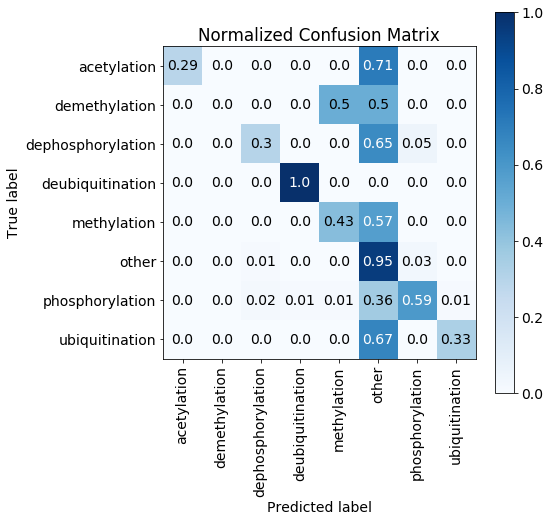

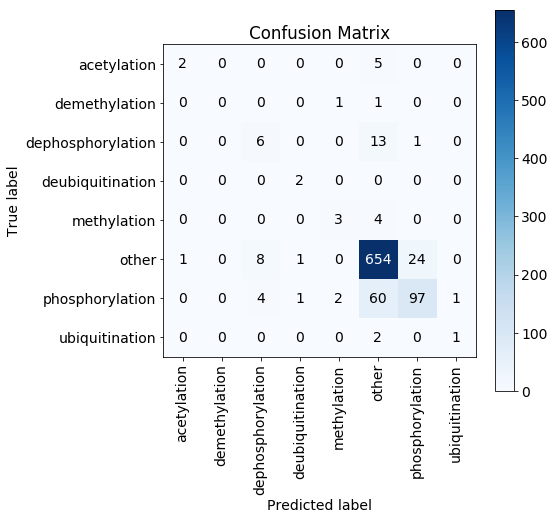

In [25]:
import matplotlib.pyplot as plt
import scikitplot as skplt

# fig = plt.figure(figsize=(7,20))
# gs = fig.add_gridspec(2, 1)


skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=True , figsize=(7,7),  x_tick_rotation=90)
plt.savefig("confusionmatrix_normalised.jpg", bbox_inches='tight')

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], figsize=(7,7), normalize=False, x_tick_rotation=90 )
plt.savefig("confusionmatrix_unnormalised.jpg", bbox_inches='tight')




In [26]:
# from sklearn.metrics import accuracy_score, accuracy_score,recall_score


# interactions = df["class"].unique()
# interactions.sort()
# #fig, ax = plt.subplots(1, len(interactions), figsize=(40,40), squeeze=False, sharey=True, sharex=True)
# fig = plt.figure(figsize=(20,20))
# gs = fig.add_gridspec(3, 3)
# #ax = fig.add_axes([0,0,1,1])
# i = 0
# avg = 'macro'
# for interaction in interactions:
#     r = i//3
#     c= i % 3
#     df_interaction_type = df.query("predicted == '{}'".format(interaction))
#     if df_interaction_type.shape[0] == 0: continue
#     ax1 = fig.add_subplot(gs[r, c])
    


#     f1 = f1_score(df_interaction_type["actual"], df_interaction_type["predicted"],average=avg, sample_weight=None)  
#     accuracy = accuracy_score(df_interaction_type["actual"], df_interaction_type["predicted"], sample_weight=None)
#     precision= precision_score(df_interaction_type["actual"], df_interaction_type["predicted"], average=avg,sample_weight=None)
#     recall = recall_score(df_interaction_type["actual"], df_interaction_type["predicted"], average=avg,sample_weight=None)
#     skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: \nPrecision {}, Recall {} \nF-score {}".format(interaction,  round(precision*100, 2),round(recall*100, 2), round(f1*100, 2)), ax= ax1)
    
# #     ax2 = fig.add_subplot(gs[i, 1])
# #     skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax2)


#     i += 1
#     #break

# plt.savefig("confusionmatrix_.jpg", bbox_inches='tight')
# plt.show()
    
    


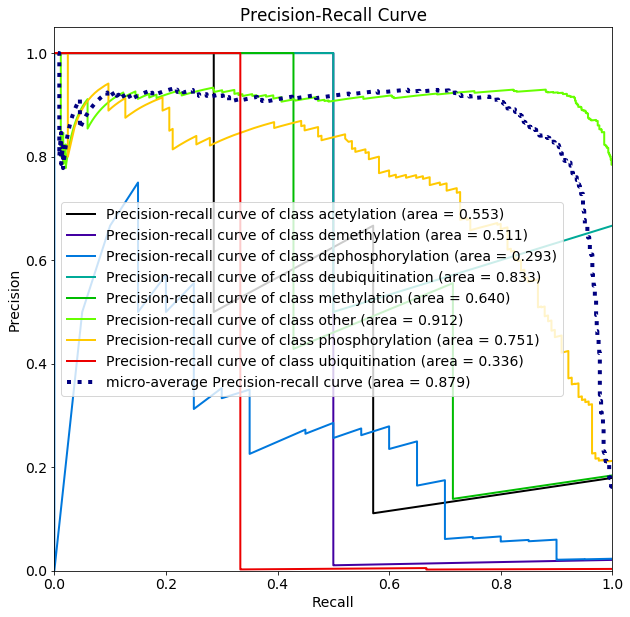

In [27]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_precision_recall(df["actual"], df[keys], figsize=(10,10))

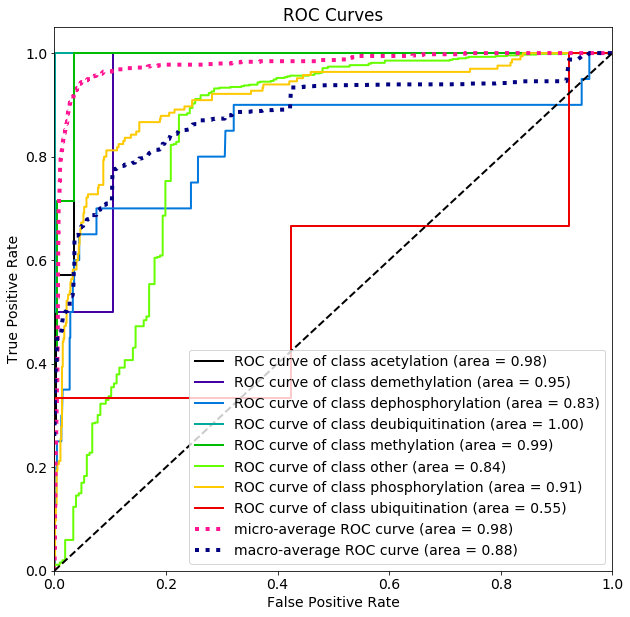

In [28]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_roc(df["actual"], df[keys], figsize=(10,10))

## Training / Validation epoch fit

In [29]:
import json
import pandas as pd
from pandas.io.json import json_normalize

def load_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)
    

In [30]:
df_train_fit = load_as_df(train_fit_file)
df_train_fit["score"] =df_train_fit["score"]* 100
df_train_fit.sort_values(["score"], ascending=False).head(n=10)

,epoch,loss,score
38,38,3.688703,98.889905
39,39,3.384684,98.826363
41,41,3.431755,98.821055
42,42,3.485756,98.761226
40,40,3.587734,98.761024
36,36,4.394363,98.748271
35,35,4.708974,98.748271
37,37,4.299220,98.696567
32,32,5.943145,98.678272
34,34,4.708471,98.663077


In [31]:
df_val_fit = load_as_df(validation_fit_file)
df_val_fit["score"] =df_val_fit["score"]* 100


df_val_fit.sort_values(["score"], ascending=False).head(n=10)

,epoch,loss,score
21,21,40.955091,56.585145
42,42,49.011612,56.058652
38,38,50.519260,55.661394
11,11,32.899003,54.753232
18,18,36.309373,53.577333
10,10,30.911157,52.665641
20,20,39.381706,52.480619
27,27,46.331764,52.012472
30,30,48.516334,51.888049
23,23,44.485245,50.584559


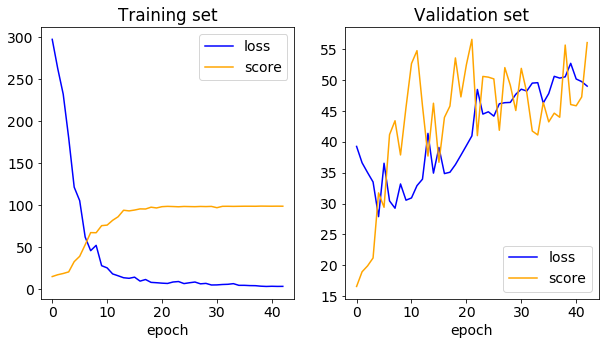

In [32]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

df_train_fit.plot.line(x="epoch", y="loss", ax = ax[0], color ="blue")
df_train_fit.plot.line(x="epoch", y="score", ax = ax[0], color="orange")
ax[0].set_title("Training set")
#ax[0].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))

df_val_fit.plot.line(x="epoch", y="loss", ax = ax[1], color="blue")
df_val_fit.plot.line(x="epoch", y="score", ax = ax[1], color ="orange")
ax[1].set_title("Validation set")
#ax[1].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))



plt.show()

### Threshold 

In [33]:
threshold = .00
key = keys[0]
df_trues = df.query("predicted_confidence >  {} and predicted == 'acetylation'".format(threshold))
print(df_trues.shape)

from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

f1 = f1_score(df_trues["actual"], df_trues["predicted"], average="macro")  
accuracy = accuracy_score(df_trues["actual"], df_trues["predicted"], sample_weight=None)
precision = precision_score(df_trues["actual"], df_trues["predicted"], average="macro", sample_weight=None)
recall = recall_score(df_trues["actual"], df_trues["predicted"], average="macro", sample_weight=None)



print("The F1 score is {} and the accuracy is {}, precision {}, recall {}".format(f1, accuracy, precision, recall))

(3, 17)
The F1 score is 0.4 and the accuracy is 0.6666666666666666, precision 0.3333333333333333, recall 0.5


/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
interactions = df_trues["interactionType"].unique()
#fig, ax = plt.subplots(1, len(interactions), figsize=(40,40), squeeze=False, sharey=True, sharex=True)
fig = plt.figure(figsize=(40,40))
gs = fig.add_gridspec(7, 1)
#ax = fig.add_axes([0,0,1,1])
i = 0
for interaction in interactions:
    print(interaction)
    df_interaction_type = df_trues.query("interactionType == '{}'".format(interaction))
    ax1 = fig.add_subplot(gs[i, 0])
    


    f1 = f1_score(df_interaction_type["actual"], df_interaction_type["predicted"], average='macro')  
    accuracy = accuracy_score(df_interaction_type["actual"], df_interaction_type["predicted"], sample_weight=None)
    skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax1)
    
#     ax2 = fig.add_subplot(gs[i, 1])
#     skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax2)


    i += 1
    #break

plt.savefig("confusionmatrix_threshold.jpg", bbox_inches='tight')
plt.show()
    

KeyError: 'interactionType'

## Filter uniprot not in train

In [ ]:
df_train = pd.read_json('train_unique_pub_v6_less_negative.json')

In [ ]:
df_train['participant1Id'].values.tolist()[0:10]

In [ ]:
train_uniprot = set(df_train['participant1Id'].values.tolist()).union(set(df_train['participant2Id'].values.tolist()))

In [ ]:
df_filtered_uniprot =df[ df.apply(lambda r : r['participant2Id'] in train_uniprot and  r['participant1Id'] in train_uniprot , axis=1)]

In [ ]:
df_filtered_uniprot.shape

In [ ]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df_filtered_uniprot["actual"], df_filtered_uniprot["predicted"], normalize=False )
plt.show()

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(df_filtered_uniprot["actual"], df_filtered_uniprot["predicted"], sample_weight=None)  
accuracy = accuracy_score(df_filtered_uniprot["actual"], df_filtered_uniprot["predicted"], sample_weight=None)
print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))




In [ ]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_precision_recall(df_filtered_uniprot["actual"], df_filtered_uniprot[["false", "true"]])

#### Impact of missing uniprot

In [ ]:
df_filtered_missing_uniprot =df[ df.apply(lambda r : r['participant2Id']  not in train_uniprot  or  r['participant1Id'] not in train_uniprot , axis=1)]

In [ ]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df_filtered_missing_uniprot["actual"], df_filtered_missing_uniprot["predicted"], normalize=False )
plt.show()

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(df_filtered_missing_uniprot["actual"], df_filtered_missing_uniprot["predicted"], sample_weight=None)  
accuracy = accuracy_score(df_filtered_missing_uniprot["actual"], df_filtered_missing_uniprot["predicted"], sample_weight=None)
print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))